In [1]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import psycopg2
from datetime import timedelta

%matplotlib inline

con = psycopg2.connect (user = 'postgres',
                password = 'postgres',
                port = '5432',
                
                database = 'inicudb')

cur  = con.cursor()

In [2]:
schemaName = "apollo"

In [3]:
cur1 = con.cursor()
cur1.execute("SELECT uhid,dischargestatus,birthweight,gestationweekbylmp,gestationdaysbylmp,dateofadmission,timeofadmission,gender,central_temp FROM "+schemaName+".baby_detail WHERE dateofadmission >= '2018-07-01' AND dateofadmission <= '2020-05-31' and UHID IN  (select distinct(uhid) from "+schemaName+".babyfeed_detail where uhid in  ( select distinct(uhid) from "+schemaName+".baby_visit where uhid in (select  distinct(uhid) from "+schemaName+".nursing_vitalparameters where uhid in ( select distinct(uhid) from "+schemaName+".device_monitor_detail UNION select distinct(uhid) from "+schemaName+".device_monitor_detail_dump)))) and (dischargestatus = 'Discharge' OR dischargestatus = 'Death' ) and isreadmitted is not true and gestationweekbylmp is not null and birthweight is not null;")
cols1 = list(map(lambda x: x[0], cur1.description))
ds = pd.DataFrame(cur1.fetchall(),columns=cols1)
#ds.sort_values('modificationtime',inplace=True)

In [4]:
uhids = ds.uhid.unique()

In [33]:
len(ds)

807

In [5]:
def birthweight_correction(x):
    if x<0.6:
        return x * 1000
    elif x<2.0 and x>1.1:
        return x * 1000
    elif x>=2.0 and x<4.0:
        return x * 1000
    else:
        return x

In [6]:
ds.birthweight = ds.birthweight.apply(birthweight_correction)

In [7]:
def start_time(x,y):
    try:
        y = str(y)
        if x.split(',')[2] == 'AM':
            return y +" "+ x.split(',')[0] +":"+ x.split(',')[1] + ".000"
        else:
            return str(pd.to_datetime(y +" "+ x.split(',')[0] +":"+ (x.split(',')[1]) + ".000") + timedelta(hours=12))
    except:
        pass

In [8]:
ds['admission_date'] = ds.apply(lambda x: start_time(x['timeofadmission'],x['dateofadmission']),axis=1)

In [9]:
ds['gestation'] = ds['gestationweekbylmp'] + ds['gestationdaysbylmp']/7.0

In [10]:
ds = ds[(ds['birthweight']<=1500) | (ds['gestation']<=31)]

In [11]:
ds.count()

uhid                  169
dischargestatus       169
birthweight           169
gestationweekbylmp    169
gestationdaysbylmp    169
dateofadmission       169
timeofadmission       169
gender                169
central_temp           16
admission_date        168
gestation             169
dtype: int64

In [12]:
def to_date(x):
    return pd.to_datetime(x)

In [13]:
ds['admission_date'] = ds['admission_date'].apply(to_date)

In [14]:
ds['CRIB_1Hr'] = ds['admission_date'] + timedelta(hours = 12)

NameError: name 'uhid' is not defined

In [15]:
#Max BE
cur2 = con.cursor()
cur2.execute("SELECT t1.uhid,t1.be,t1.modificationtime FROM apollo.nursing_bloodgas AS t1")
cols2 = list(map(lambda x: x[0], cur2.description))
be = pd.DataFrame(cur2.fetchall(),columns=cols2)
#ds.sort_values('modificationtime',inplace=True)

In [47]:
be

,uhid,be,modificationtime
0,RSHI.0000006352,None,2017-08-23 16:50:43.306798
1,RSHI.0000006352,None,2017-08-23 16:52:33.241413
2,RSHI.0000006352,None,2017-08-23 17:26:43.904732
3,RSHI.0000006352,12,2017-08-23 17:34:56.742368
4,RSHI.0000006352,12,2017-08-23 17:44:52.288618
5,RSHI.0000006352,14,2017-08-23 18:01:07.075524
6,RSHI.0000006514,-22,2017-08-16 16:43:34.353000
7,RSHI.0000006514,-22,2017-08-16 19:55:50.590000
8,RSHI.0000006514,-22,2017-08-16 15:50:55.970000
9,RSHI.0000006514,10,2017-08-16 23:00:28.367000


In [17]:
be_1 = pd.DataFrame(columns=be.columns)
for i in uhids:
    try:
        x = be[be['uhid']==i]
        if(len(x) > 0):
            u = ds[ds['uhid']==i]
            if(len(u) > 0):
                j = u.CRIB_1Hr.iloc[0]

                x = x[x['modificationtime']<=j]
                be_1 = be_1.append(x,ignore_index=True)
    except Exception as e:
        print(r,"error")
        

In [18]:
#Max and Min
cur3 = con.cursor()
cur3.execute("SELECT t1.uhid,t1.fio2,t1.start_time,t1.modificationtime FROM apollo.device_ventilator_detail AS t1 UNION SELECT t2.uhid,t2.fio2,t2.start_time,t2.modificationtime FROM apollo.device_ventilator_detail_dump AS t2 ;")
cols3 = list(map(lambda x: x[0], cur3.description))
fio2 = pd.DataFrame(cur3.fetchall(),columns=cols3)
#ds.sort_values('modificationtime',inplace=True)

In [19]:
fio2_1 = pd.DataFrame(columns=fio2.columns)

In [21]:
for i in uhids:
    try:
        x = fio2[fio2['uhid']==i]
        u = ds[ds['uhid']==i]
        j = u.CRIB_1Hr.iloc[0]
        

        x = x[x['modificationtime']<=j]
        print(i)
        fio2_1 = fio2_1.append(x,ignore_index=True)
        
    except:
        p = 1

RSHI.0000021953
RNEH.0000013244
RNEH.0000014505
RSHI.0000022306
RSHI.0000024036
RSHI.0000022118
RSHI.0000017430
RSHI.0000022137
RSHI.0000022270
RSHI.0000023343
RSHI.0000016530
RSHI.0000022450
RSHI.0000021806
RSHI.0000024071
RSHI.0000012827
RSHI.0000019945
RSHI.0000019884
RSHI.0000012831
RSHI.0000019707
RNEH.0000013236
RNEH.0000010725
RSHI.0000019496
RSHI.0000020326
RMAR.0000026647
RNEH.0000010724
RSHI.0000019631
RNEH.0000010531
RSHI.0000014261
RNEH.0000010783
RNEH.0000010784
RSHI.0000022489
RSHI.0000012828
RSHI.0000016565
RSHI.0000016666
RNEH.0000010413
RSHI.0000020604
RNEH.0000012325
RSHI.0000018972
RNEH.0000012326
RSHI.0000016283
RJUB.12475
RSHI.0000014097
RSHI.0000018016
RNEH.0000012581
RSHI.0000014510
RSHI.0000022235
RSHI.0000018153
RNEH.0000010414
RSHI.0000017931
RSHI.0000018152
RSHI.0000022514
RSHI.0000012830
RSHI.0000018556
RSHI.0000014677
RNEH.0000011301
RNEH.0000011300
RSHI.0000017787
RSHI.0000020758
RSHI.000001984
RSHI.0000019951
RNEH.0000011749
RSHI.0000019960
RSHI.000001917

In [22]:
test = be.drop_duplicates('uhid',keep='first')

In [23]:
test.count()

uhid                681
be                  310
modificationtime    681
dtype: int64

In [24]:
def to_float(x):
    try:
        return float(x)
    except:
        pass

In [25]:
fio2_1.fio2 = fio2_1.fio2.apply(to_float)

In [26]:
fio2_max_min = pd.DataFrame(columns=['uhid','max_fio2','min_fio2'])

In [27]:
#Calculating Maximum and Minimum FiO2
for i in fio2_1.uhid.unique():
    x = fio2_1[fio2_1['uhid']==i]
    
    fio2_max_min = fio2_max_min.append({'uhid':i,'max_fio2':x['fio2'].max(),'min_fio2':x['fio2'].min()},ignore_index=True)

In [28]:
be_max = pd.DataFrame(columns=['uhid','max_be'])

In [29]:
be_1.be = be_1.be.apply(to_float)

In [30]:
be_1.count()

uhid                54
be                  11
modificationtime    54
dtype: int64

In [31]:
#Calculating Maximum Base Excess
for i in be_1.uhid.unique():
    x = be_1[be_1['uhid']==i]
    
    be_max = be_max.append({'uhid':i,'max_be':x['be'].max()},ignore_index=True)

In [32]:
df = pd.merge(ds,fio2_max_min,on=['uhid'],how='left',copy=False)

In [33]:
data = pd.merge(df,be_max,on=['uhid'],how='left',copy=False)

In [35]:
complete_df = pd.DataFrame(columns=data.columns)
for i in uhids:
    x = data[data['uhid']==i]
    complete_df = complete_df.append(x,ignore_index=True)

In [36]:
#imputing the missing fio2 values with 21% which is the normal fio2 level when baby is breathing normally
complete_df.max_fio2 = complete_df.max_fio2.fillna(21)
complete_df.min_fio2 = complete_df.min_fio2.fillna(21)

In [33]:
#complete_df.dropna()

In [37]:
len(fio2_1[fio2_1['fio2']>21].uhid.unique())

0

In [38]:
complete_df.max_be = complete_df.max_be.fillna(3)

In [77]:
complete_df.count()

uhid                  163
dischargestatus       163
birthweight           163
gestationweekbylmp    163
gestationdaysbylmp    163
dateofadmission       163
timeofadmission       163
gender                163
central_temp           16
admission_date        162
gestation             163
CRIB_1Hr              162
max_fio2              163
min_fio2              163
max_be                163
dtype: int64

In [39]:
complete_df = complete_df.drop_duplicates(subset=['uhid'])

In [40]:
def bw(x):
    if x>1350.0:
        return 0
    elif x>850.0 and x<=1350.0:
        return 1
    elif x>701.0 and x<=850.0:
        return 4
    else:
        return 7

In [41]:
def ga(x):
    if x>24.0:
        return 0
    else:
        return 1    
    
def be(x):
    if x>7.0:
        return 0
    elif x>-9.9 and x<=-7.0:
        return 1
    elif x>-14.9 and x<=-10.0:
        return 2
    else:
        return 4

def min_fio2_FUNC(x):
    if x<40.0:
        return 0
    elif x>41.0 and x<=80.0:
        return 2
    elif x>81.0 and x<=90.0:
        return 3
    else:
        return 4

def max_fio2_FUNC(x):
    if x<40.0:
        return 0
    elif x>41.0 and x<=80.0:
        return 1
    elif x>81.0 and x<=90.0:
        return 3
    else:
        return 5


In [42]:
complete_df['CRIB'] = complete_df.birthweight.apply(bw) + complete_df.gestationweekbylmp.apply(ga) + complete_df.max_be.apply(be) + complete_df.min_fio2.apply(min_fio2_FUNC)+complete_df.max_fio2.apply(max_fio2_FUNC)

In [43]:
def crib_prob(x):
    if x>=15:
        return 1.0
    elif x>11 and x<=15:
        return 0.73
    elif x>6 and x<=10:
        return 0.55
    else:
        return 0.09

In [44]:
complete_df['pred'] = complete_df.CRIB.apply(crib_prob)

In [45]:
def bina(x):
    if x == 'Death':
        return 1
    else:
        return 0

In [46]:
complete_df.dischargestatus = complete_df.dischargestatus.apply(bina)

In [47]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve\


lr_fpr, lr_tpr, _ = roc_curve(complete_df.dischargestatus,complete_df.pred,drop_intermediate=False)

In [48]:
import matplotlib.pyplot as plt

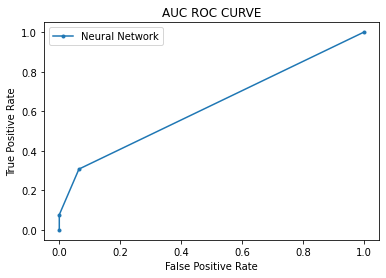

In [49]:
plt.title('AUC ROC CURVE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.plot(cr_fpr, cr_tpr, linestyle='--',linewidth=3, label='CRIB')
#plt.plot(cr2_fpr, cr2_tpr, 'r+',linestyle='--', label='CRIB II')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Neural Network')
#plt.plot(ns_fpr, ns_tpr, linestyle='--', label='SNAPPE II')
#plt.plot(ns2_fpr, ns2_tpr, linestyle='--', label='SNAP II')
#plt.plot(log_fpr, log_tpr, marker='.', label='Logistic Regression')
plt.legend(loc=0)
#plt.savefig('AUC_2.png',dpi=1200)

In [50]:
roc_auc_score(complete_df.dischargestatus,complete_df.pred)

0.6240694789081886

In [51]:
ds = pd.DataFrame(complete_df.pred)
ds['true_outcome'] = complete_df.dischargestatus

In [52]:
def classify(x):
    if x>0.5:
        return 1
    else:
        return 0

In [53]:
complete_df.pred_1 = complete_df.pred.apply(classify)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [54]:
#reports
#Results might vary with each iteration as Deep Neural Networks,initially assigns random weights.
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(complete_df.dischargestatus,complete_df.pred_1))
print(confusion_matrix(complete_df.dischargestatus,complete_df.pred_1))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       155
           1       0.29      0.31      0.30        13

    accuracy                           0.89       168
   macro avg       0.61      0.62      0.62       168
weighted avg       0.89      0.89      0.89       168

[[145  10]
 [  9   4]]


In [53]:
#complete_df.to_csv('CRIB_10_Jan_2.csv')

In [95]:
len(ds)

162

In [55]:
33/2

16.5

In [96]:
crib = pd.DataFrame(complete_df.dischargestatus)

In [97]:
crib['pred'] = complete_df.pred

In [98]:
crib.to_csv('crib_auc_new.csv')

In [99]:
crib

,dischargestatus,pred
0,1,0.55
1,1,0.55
2,1,0.09
3,1,0.09
4,1,0.09
5,1,0.09
6,1,0.09
7,1,0.55
8,1,0.73
9,1,0.09
